In [1]:
%load_ext autoreload
%autoreload 2
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from time import time
import genA
import plot
import findIdx
import simTraj
import train

# Set a fixed seed
SEED = 42

# NumPy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# Make a root SeedSequence
ss = np.random.SeedSequence(42)
#  Spawn child seeds (still SeedSequence objects)
ss1, ss2 = ss.spawn(2)
# Turn each into a Generator
rng1 = np.random.default_rng(ss1)
rng2 = np.random.default_rng(ss2)


### Data Collection

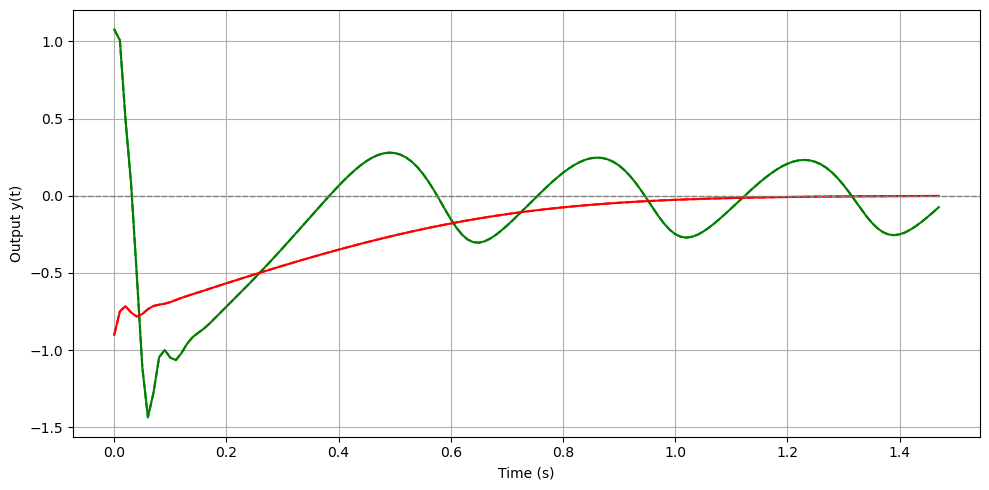

In [2]:
# --- NARX system definition ---
def polynomial_narx(y_k, y_km1, u_km1, u_k):
    a1, a2 = 1, -0.5
    b1 = 0.5
    c = 1
    y_next = a1 * np.sin(y_k) + a2 * np.cos(y_km1) + b1 * u_km1 +  c * u_k
    return y_next

# --- Simulation parameters ---
timesteps = 150
dt = 0.01

# --- Set offline measurement noise std ---
# offlineStd = 1e-1 
offlineStd = 0
# --- Set online measurement noise std ---
# onlineStd=1e-1
onlineStd=0

# --- Run two trajectories with different initial conditions and PI gains ---
y_init1 = [2.0, 2.0]
u_init1 = [0.0]
(traj1True, traj1Meas, XI1, U1) = simTraj.simulate_trajectory_pid(y_init1, u_init1, polynomial_narx, timesteps, dt, std=offlineStd, Kp=0, Ki=2, Kd=0, rng = rng1)

y_init2 = [-1.0, -1.0]
u_init2 = [0.0]
(traj2True, traj2Meas,  XI2, U2) = simTraj.simulate_trajectory_pid(y_init2, u_init2, polynomial_narx, timesteps, dt, std=offlineStd, Kp=0.2, Ki=1, Kd=0, rng = rng2)

# --- Combine data ---
XI = np.vstack((XI1, XI2))
U = np.hstack((U1, U2))

plot.plotTrain(traj1True, traj1Meas, traj2True, traj2Meas, dt)

### Learning the inverse model

In [3]:
# --- Convert input and output training data from NumPy arrays to PyTorch tensors ---
train_x = torch.from_numpy(XI).float()
train_y = torch.from_numpy(U).float()

# --- Number of training iterations for GP model optimization ---
training_iter = 800

if offlineStd == 0:
    # If no noise -> train standard GP model
    model, likelihood = train.trainGPmdl(train_x, train_y, training_iter)
else:
    # If noise -> train ARD (Automatic Relevance Determination) GP model
    ard_num_dims = train_x.shape[1]
    model, likelihood = train.trainGPmdlARD(train_x, train_y, training_iter, ard_num_dims)

# --- Compute the RKHS norm of the GP posterior mean function --- 
rkhs_norm = train.compute_rkhs_norm(model, train_x, train_y)
print(f"RKHS norm of posterior mean: {rkhs_norm:.4f}")

# --- Switch model and likelihood to evaluation mode ---
model.eval()
likelihood.eval()

# --- Make predictions on training data ---
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = model(train_x)
    u_pred = preds.mean
    max_error = torch.max(torch.abs(u_pred - train_y)).item()

print(f"Maximum absolute prediction error on training data: {max_error:.4f}")

slope = train.compute_gamma(model,rkhs_norm)
def gammaInv(eps):
    return  eps / slope


Iter 1/800 - Loss: 0.770
Iter 101/800 - Loss: 0.351
Iter 201/800 - Loss: -0.141
Iter 301/800 - Loss: -0.657
Iter 401/800 - Loss: -1.169
Iter 501/800 - Loss: -1.663
Iter 601/800 - Loss: -2.124
Iter 701/800 - Loss: -2.530
Iter 800/800 - Loss: -2.856
RKHS norm of posterior mean: 3.8753
Maximum absolute prediction error on training data: 0.0388
Lengthscale: 2.4492170810699463
Outputscale: 0.5952733755111694
Taylor expansion slope: 6.6857404708862305


c:\Users\user\anaconda3\envs\oPGIGP\lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


### Compute $(\mathcal{A}_\delta^j)_{j=0}^{\bar{\kappa}}$ for every $\delta\in\Delta$

In [4]:
# --- Define the set of deltas ---
Delta = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.8,1,1.5,2,3])  
# --- Maximum iteration depth ---
kbar = 20       
# --- Desired target value for output y ---                 
y_goal = 0.0

# --- Generate and store A_\delta^j ---
A_all = {}  

for delta in Delta:
    A = genA.genA(delta, XI, U, kbar, y_goal, gammaInv)
    A_all[delta] = A  


In [5]:
# --- Construct ZETA from XI ---
ZETA     = XI[:-1, 1:4]

# --- Define different initial states [y(-1), y(-2), u(-1)] ---
curr_state1 = np.array([y_init1[0], y_init1[1], u_init1[0]])
curr_state2 = np.array([y_init2[0], y_init2[1], u_init2[0]])
curr_state3 = np.array([1, 1, 0])

# --- Number of simulation timesteps ---
simTimesteps = 150

# --- Run trajectory simulations for different initial states and noise settings ---
init_states = [curr_state1, curr_state2, curr_state3]
noise_levels = [onlineStd, 0]   # online noise and no noise

trajectory_sims = [] 
states_sims = []

for noise_val in noise_levels:
    for init_state in init_states:
        traj, states = simTraj.simulate_trajectory(
            polynomial_narx, init_state, A_all, XI, ZETA,
            model, likelihood, simTimesteps, noise_val, rng1
        )
        trajectory_sims.append(traj)
        states_sims.append(states)


c:\Users\user\OneDrive\과제\AIM\코드\OutputPGIGP\gPyTorchSimul\plot.py:260: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


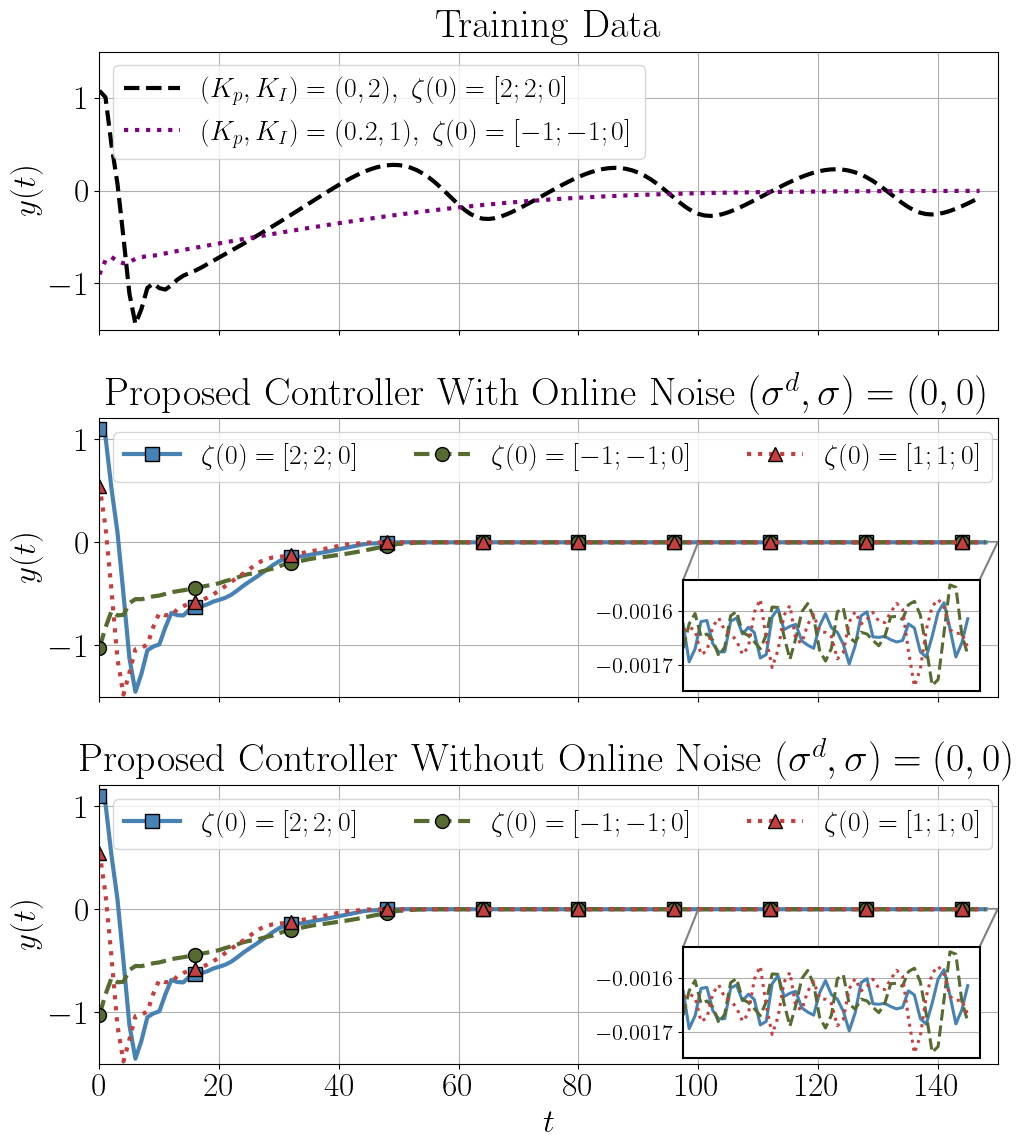

In [6]:
# --- Plot result ---
plot.plotResult(traj1Meas,traj2Meas,trajectory_sims,simTimesteps,offlineStd,onlineStd)

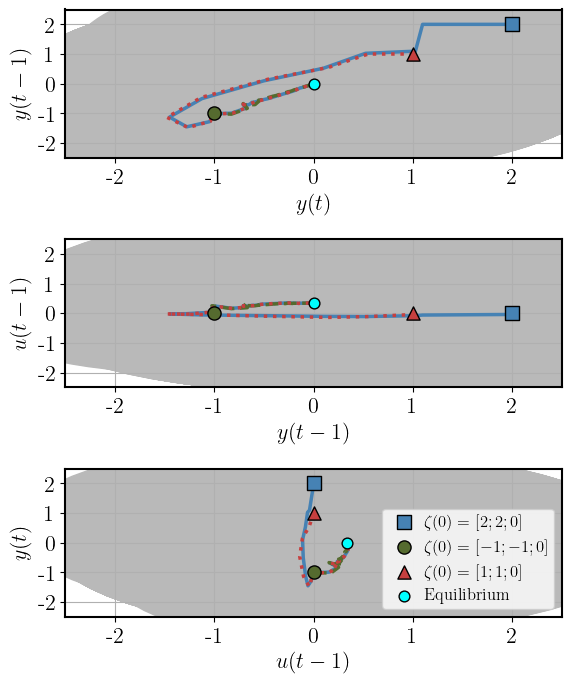

In [7]:
plot.plotA(A_all, XI, Delta, kbar, states_sims)